In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv, find_dotenv
import os
from datetime import date

pd.set_option("display.max_columns", None)


In [15]:
dotenv_path = find_dotenv()
load_dotenv(dotenv_path)
FACEIT_PLAYERID = os.environ.get("FACEIT_PLAYERID")


In [16]:
DF_all = pd.read_pickle("./AllDatabz2.pkl", compression="bz2")


In [17]:
DF_me = DF_all.query("PlayerId == @FACEIT_PLAYERID")

In [18]:
DF_me["index"] = np.arange(len(DF_me))

C:\Users\dima1\AppData\Local\Temp\ipykernel_31512\2280133688.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DF_me["index"] = np.arange(len(DF_me))


In [19]:
DF_me

,index,PlayerId,Kills,Assists,Deaths,Mvps,Headshots%,Score,Map,Result,CreatedAt,SteamData,Rounds,DateOrdinal,Year,Month,Day
7184,0,2fb9fe10-5c7e-4f2f-860b-a9ee2f88801a,1,0,10,0,100,11:1,de_cbble,Lose,2017-03-17 13:00:31.295,False,12,736405,2017,3,17
7195,1,2fb9fe10-5c7e-4f2f-860b-a9ee2f88801a,11,6,26,0,27,16:14,de_dust2,Lose,2017-03-17 13:46:49.379,False,30,736405,2017,3,17
7909,2,2fb9fe10-5c7e-4f2f-860b-a9ee2f88801a,2,0,18,0,100,2:16,de_mirage,Lose,2017-03-28 05:56:43.670,False,18,736416,2017,3,28
17307,3,2fb9fe10-5c7e-4f2f-860b-a9ee2f88801a,7,1,13,0,43,16:3,de_overpass,Win,2017-08-10 09:25:16.440,False,19,736551,2017,8,10
17327,4,2fb9fe10-5c7e-4f2f-860b-a9ee2f88801a,0,2,9,0,0,12:2,de_cache,Lose,2017-08-10 09:59:57.155,False,14,736551,2017,8,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390844,889,2fb9fe10-5c7e-4f2f-860b-a9ee2f88801a,45,7,15,8,48,13:16,de_mirage,Win,2023-07-04 14:45:58.000,True,29,738705,2023,7,4
390849,890,2fb9fe10-5c7e-4f2f-860b-a9ee2f88801a,18,2,4,4,33,16:1,de_mirage,Win,2023-07-04 15:43:26.000,True,17,738705,2023,7,4
392568,891,2fb9fe10-5c7e-4f2f-860b-a9ee2f88801a,24,8,18,3,33,16:12,de_mirage,Win,2023-07-24 12:47:49.000,True,28,738725,2023,7,24
392577,892,2fb9fe10-5c7e-4f2f-860b-a9ee2f88801a,13,6,14,3,38,5:16,de_mirage,Win,2023-07-24 14:43:01.000,True,21,738725,2023,7,24


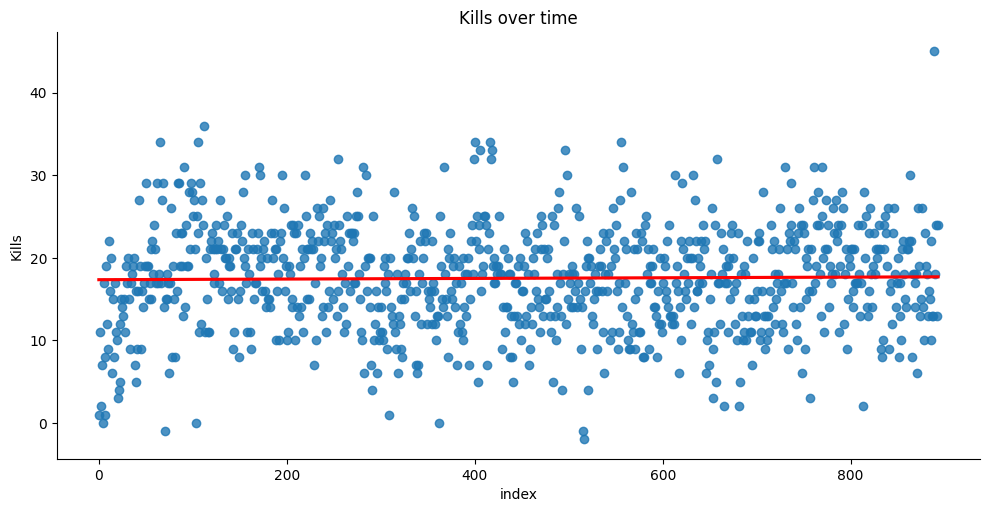

In [20]:
g = sns.lmplot(
    data=DF_me,
    x="index",
    y="Kills",
    ci=0,
    line_kws={"color": "red"},
    facet_kws=dict(sharex=False, sharey=True),
    aspect=2
)
plt.title("Kills over time")
# for ax in g.axes.flat:
#     new_labels = [
#         date.fromordinal(int(item)).strftime("%m/%Y") for item in ax.get_xticks()
#     ]
#     ax.set_xticklabels(new_labels, rotation=30)
#     ax.set_xlabel("Date")
#     ax.set_title("Kills over time")

plt.show()


C:\Users\dima1\AppData\Local\Temp\ipykernel_31512\4020954507.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, rotation=30)
C:\Users\dima1\AppData\Local\Temp\ipykernel_31512\4020954507.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, rotation=30)
C:\Users\dima1\AppData\Local\Temp\ipykernel_31512\4020954507.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, rotation=30)
C:\Users\dima1\AppData\Local\Temp\ipykernel_31512\4020954507.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, rotation=30)
C:\Users\dima1\AppData\Local\Tem

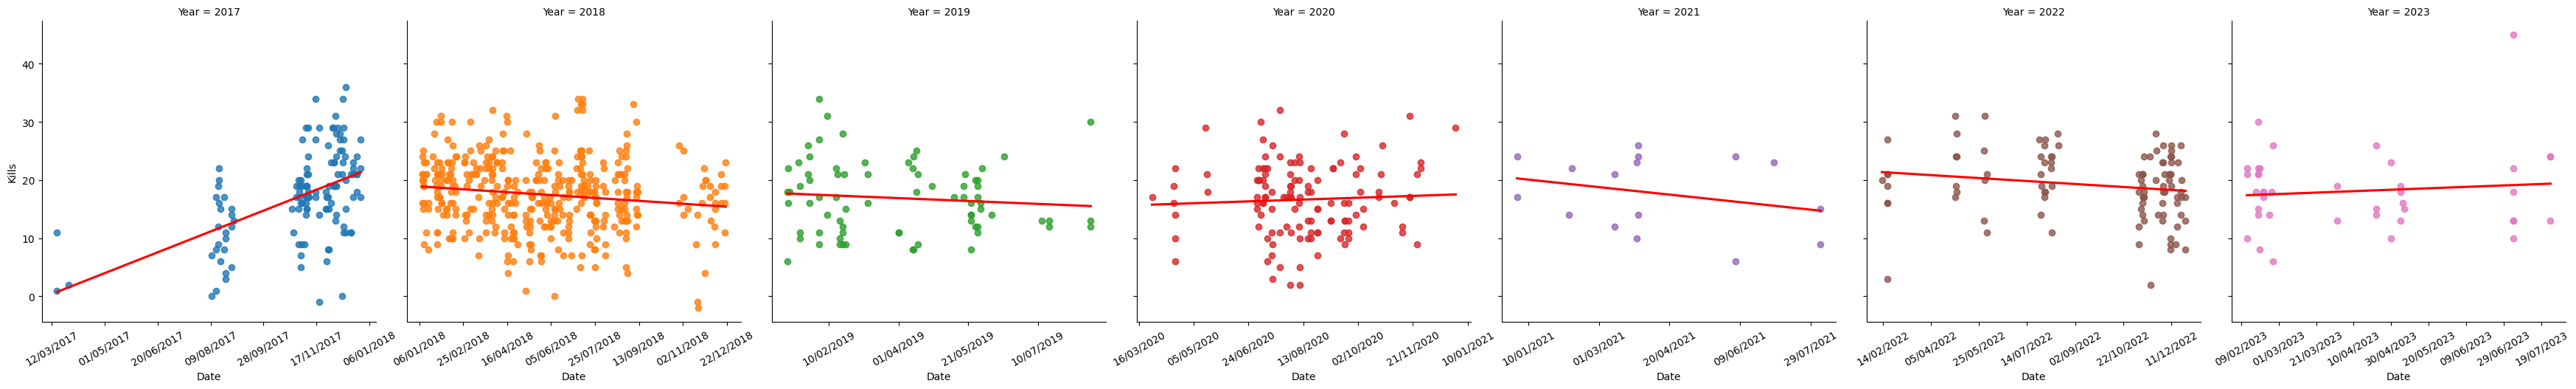

In [21]:
g = sns.lmplot(
    data=DF_me,
    x="DateOrdinal",
    y="Kills",
    ci=None,
    col="Year",
    hue="Year",
    line_kws={"color": "red"},
    facet_kws=dict(sharex=False, sharey=True),
)
# plt.title("Kills over time")
for ax in g.axes.flat:
    new_labels = [
        date.fromordinal(int(item)).strftime("%d/%m/%Y") for item in ax.get_xticks()
    ]
    ax.set_xticklabels(new_labels, rotation=30)
    ax.set_xlabel("Date")
    # ax.set_title("Kills over time in 2018")
plt.show()


In [22]:
DF_me.select_dtypes(include=np.number).columns.tolist()
Maps = (
    DF_me.groupby(by="Map")
    .aggregate(
        {
            "Kills": sum,
            "Deaths": sum,
            "Mvps": sum,
            "Map": "count",
            "Headshots%": "mean",
            "Result": lambda x: pd.value_counts(x)[0],
        }
    )
    .rename({"Map": "TimesPlayed"}, axis=1)
)


C:\Users\dima1\AppData\Local\Temp\ipykernel_31512\2277180220.py:3: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  DF_me.groupby(by="Map")
C:\Users\dima1\AppData\Local\Temp\ipykernel_31512\2277180220.py:3: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  DF_me.groupby(by="Map")
C:\Users\dima1\AppData\Local\Temp\ipykernel_31512\2277180220.py:11: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  "Result": lambda x: pd.value_counts(x)[0],
C:\Users\dima1\AppData\Local\Temp\ipykernel_31512\2277180220.py:11: FutureWarning: Series.__getitem__ trea

In [23]:
Maps

,Kills,Deaths,Mvps,TimesPlayed,Headshots%,Result
Map,,,,,,
de_cache,2153,2144,280,124,44.274194,57
de_cbble,190,194,26,11,50.181818,6
de_dust2,953,868,133,51,43.490196,24
de_inferno,549,564,66,36,42.638889,19
de_mirage,10753,10013,1469,602,45.875415,294
de_nuke,80,80,11,4,47.500000,2
de_overpass,872,946,110,55,45.363636,31
de_train,107,195,9,11,41.545455,10


StopIteration: 

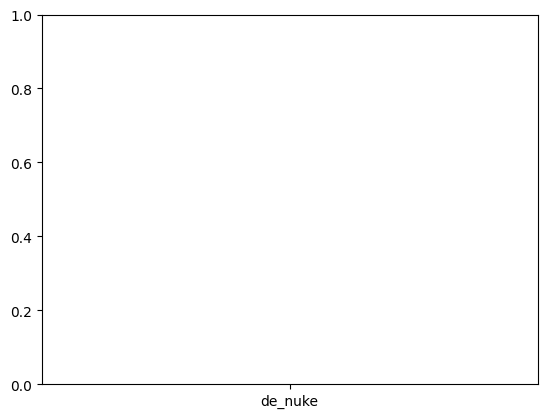

In [24]:
ax = sns.barplot(
    data=Maps,
    y="TimesPlayed",
    x=Maps.index,
    order=Maps.sort_values(by="TimesPlayed").index,
)
ax.bar_label(ax.containers[0], fontsize=10)



In [ ]:
Maps["WinRate%"] = (Maps["Result"] / Maps["TimesPlayed"] * 100).astype(int)


In [ ]:
Maps.sort_values(by="TimesPlayed", inplace=True, ascending=False)
Maps["K/D"] = round(Maps["Kills"] / Maps["Deaths"], 2)


In [ ]:
def func(pct, allvalues):
    absolute = max(int(pct / 100 * np.sum(allvalues)), 1)
    return "{:.1f}%\n({:d} games)".format(pct, absolute)


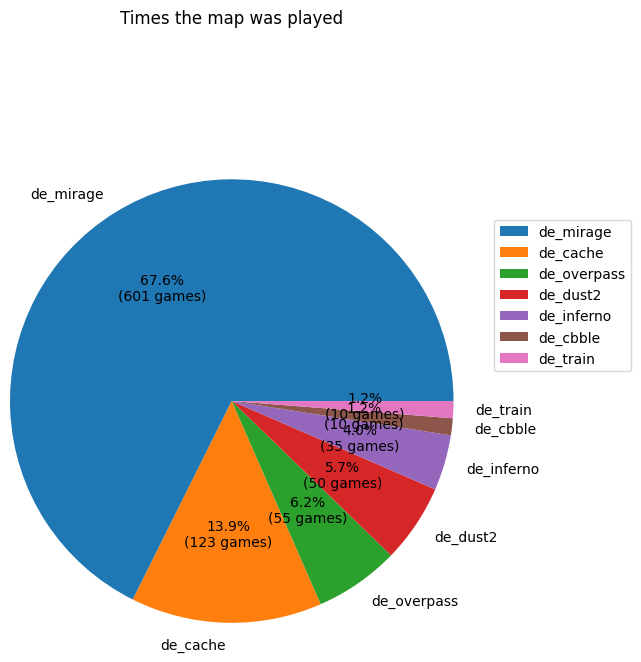

In [ ]:
fig, ax = plt.subplots()
data = Maps.query("TimesPlayed > 10")["TimesPlayed"]
p, tx, autotexts = ax.pie(
    data, labels=data.index, autopct=lambda pct: func(pct, data), radius=1.5
)
ax.xaxis.set_label_position("top")
ax.set_title("Times the map was played", y=1.5)

plt.legend(bbox_to_anchor=(1.6, 1.01))
plt.show()


In [ ]:
data

Map
de_mirage      602
de_cache       124
de_overpass     55
de_dust2        51
de_inferno      36
de_cbble        11
de_train        11
Name: TimesPlayed, dtype: int64

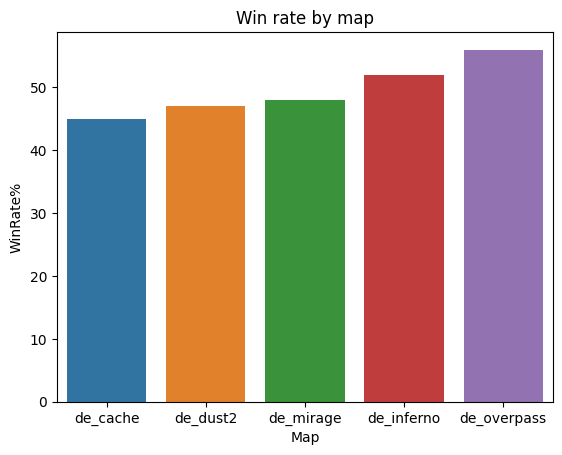

In [ ]:
fig, ax = plt.subplots()
data = Maps.query("Result > 10").sort_values(by = "WinRate%")

sns.barplot(data = data, x = data.index, y = "WinRate%")
# ax.bar(x = data.index, height)
# ax.xaxis.set_label_position("top")
plt.title("Win rate by map")
# ax.set_title("Times the map was won", y=1.5)
# plt.legend(bbox_to_anchor=(1.6, 1.01))
plt.show()


In [ ]:
# fig, ax = plt.subplots()
# data = Maps.query("Result > 10")["Result"]

# ax.pie(
#     data,
#     labels=data.index,
#     autopct=lambda pct: func(pct, data),
#     radius=1.5,
# )
# ax.xaxis.set_label_position("top")
# ax.set_title("Times the map was won", y=1.5)
# plt.legend(bbox_to_anchor=(1.6, 1.01))
# plt.show()


In [ ]:
def heatmap(data, title=""):
    corr = data.corr()
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(corr, cmap="coolwarm", vmin=-1, vmax=1)
    fig.colorbar(cax)
    ticks = np.arange(0, len(corr.columns), 1)
    ax.set_xticks(ticks)
    plt.xticks(rotation=45)
    ax.set_yticks(ticks)
    ax.set_xticklabels(corr.columns)
    ax.set_yticklabels(corr.columns)

    matrix = pd.DataFrame(data.corr(method="pearson")).round(2)
    for i in range(len(matrix)):
        for j in range(len(matrix.iloc[0])):
            text = ax.text(j, i, matrix.iloc[i, j], ha="center", va="center", color="w")
    ax.set_title(title, pad=20)


C:\Users\dima1\AppData\Local\Temp\ipykernel_25332\2157301004.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = data.corr()
C:\Users\dima1\AppData\Local\Temp\ipykernel_25332\2157301004.py:14: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  matrix = pd.DataFrame(data.corr(method="pearson")).round(2)


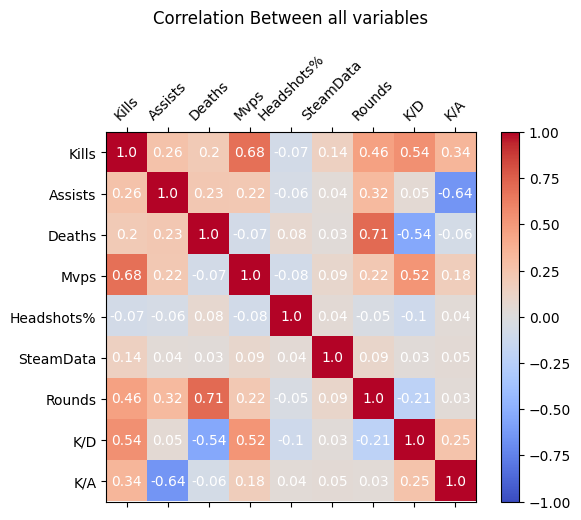

In [ ]:
heatmap(
    DF_me.drop(columns=["Year", "Month", "Day", "DateOrdinal", "index", "level_0"]),
    title="Correlation Between all variables",
)
# there is a correlation between installs and rating count -> more people installs leads to more people commenting
# next to no correlaiton between everything


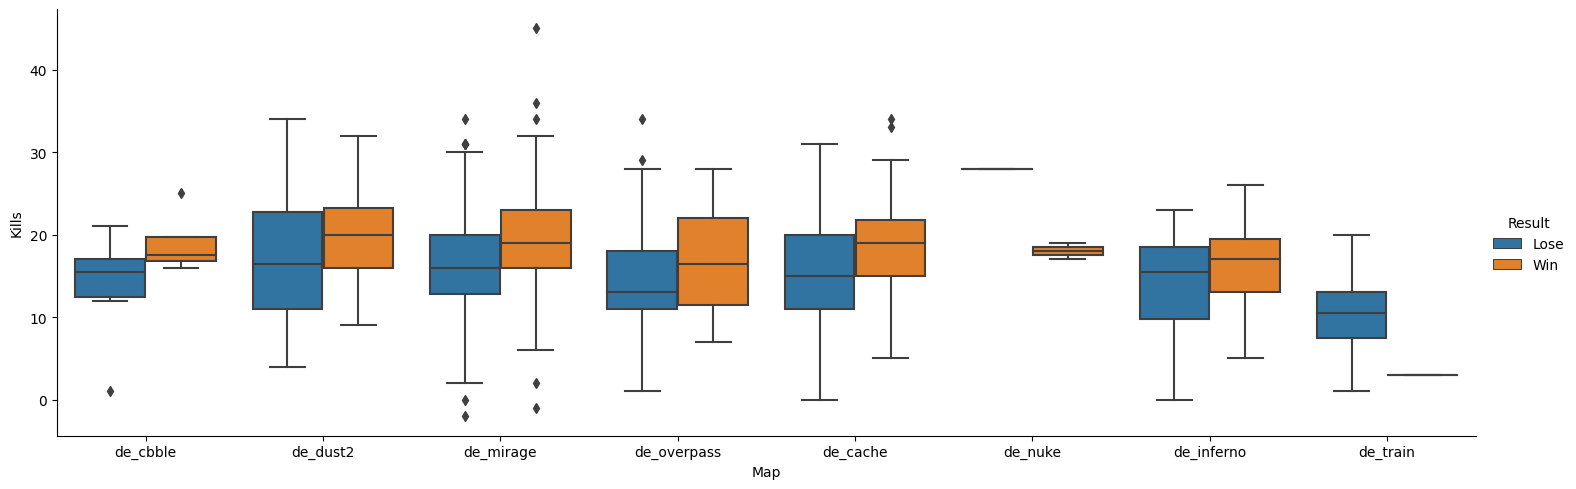

In [ ]:
mean = DF_me["Kills"].mean()

ax = sns.catplot(
    data=DF_me.query("Result in ['Lose', 'Win']"), y="Kills", x="Map", hue="Result", kind="box", aspect=3
)

# ax.axhline(mean, color=".3", dashes=(2, 2))
plt.show()


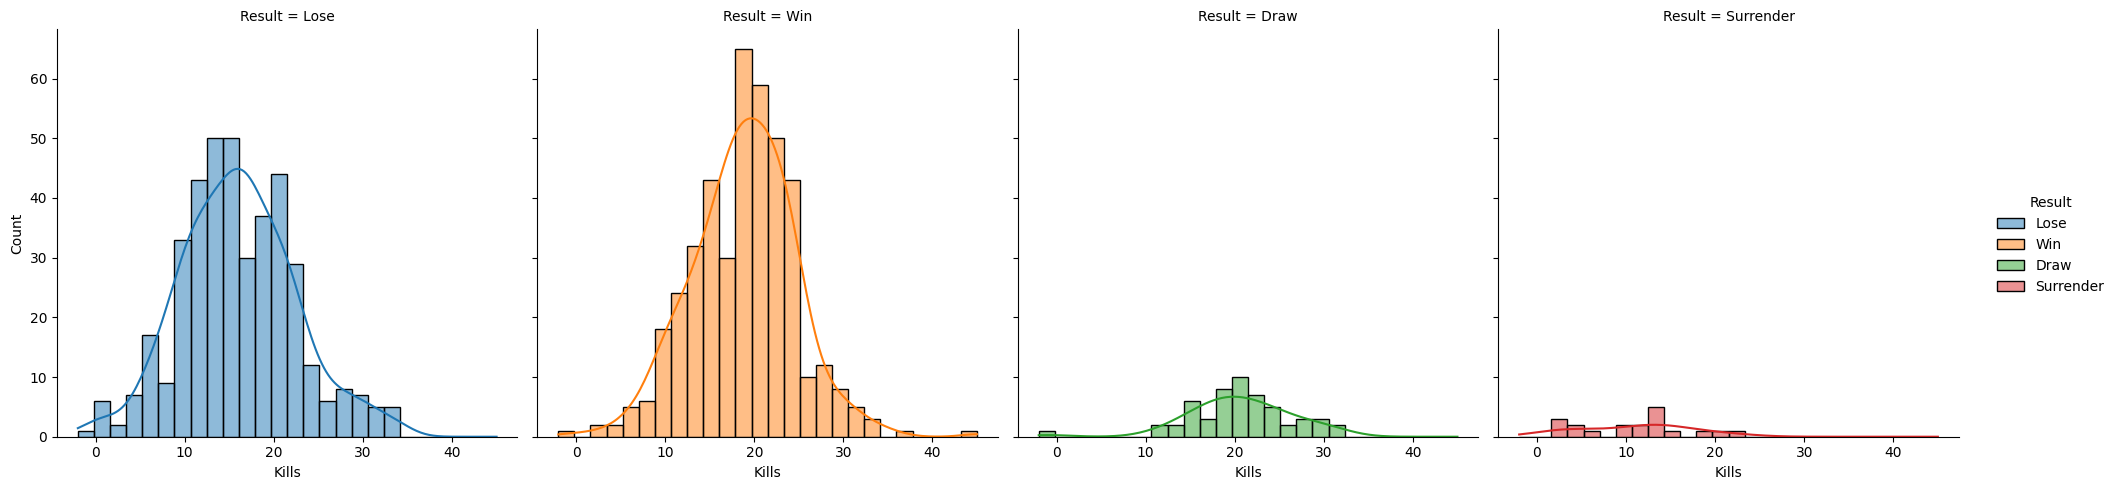

In [ ]:
sns.displot(
    data=DF_me,
    x="Kills",
    col="Result",
    hue="Result",
    kde=True,
    facet_kws=dict(sharex=False, sharey=True),
)


In [ ]:
def count_wins(x):
    wins = pd.value_counts(x).get("Win")
    if wins:
        return wins
    else:
        return 0


In [ ]:
YearlyData = (
    DF_me.groupby(["Year", "Month"], as_index=False)
    .aggregate(
        {
            "Kills": "sum",
            "Assists": "sum",
            "Deaths": "sum",
            "Headshots%": "mean",
            "Map": "count",
            "Result": lambda x: count_wins(x),
        }
    )
    .rename({"Map": "TimesPlayed", "Result": "TimesWon"}, axis=1)
)


In [ ]:
YearlyData.head()


,Year,Month,Kills,Assists,Deaths,Headshots%,TimesPlayed,TimesWon
0,2017,3,14,6,54,75.666667,3,0
1,2017,8,264,108,408,33.208333,24,10
2,2017,10,106,33,124,48.285714,7,3
3,2017,11,833,180,714,43.812500,48,22
4,2017,12,1023,232,743,40.333333,48,27


In [ ]:
YearlyData["WinRate"] = (
    YearlyData["TimesWon"] / YearlyData["TimesPlayed"] * 100
).astype(int)


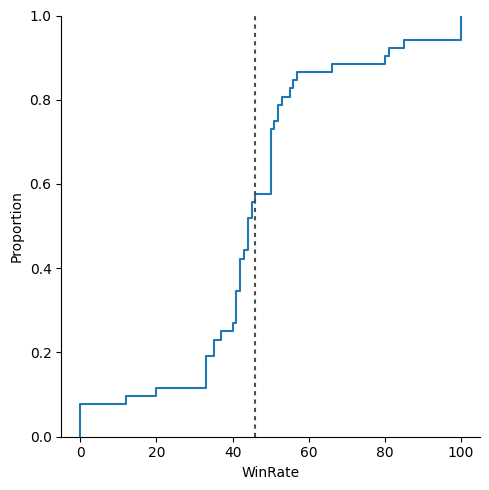

In [ ]:
winrate = YearlyData["WinRate"].mean()
g = sns.displot(data=YearlyData, x="WinRate", kind="ecdf")
for ax in g.axes.flat:
    ax.axvline(x=winrate, color=".3", dashes=(2, 2))
plt.show()


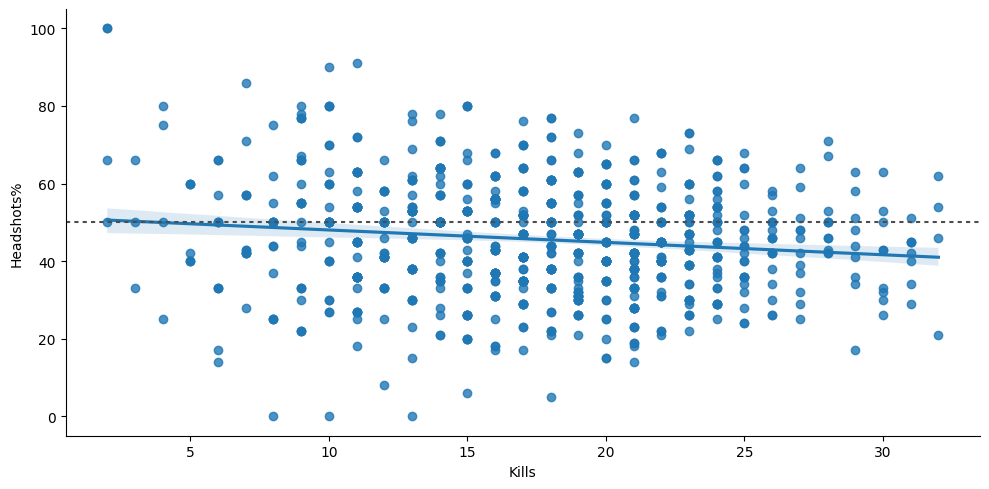

In [ ]:
q_low = DF_me["Kills"].quantile(0.01)
q_hi = DF_me["Kills"].quantile(0.99)

DF_filtered = DF_me[(DF_me["Kills"] < q_hi) & (DF_me["Kills"] > q_low)]
g = sns.lmplot(data=DF_filtered, y="Headshots%", x="Kills", aspect=2)
for ax in g.axes.flat:
    ax.axhline(50, color=".3", dashes=(2, 2))
plt.show()


C:\Users\dima1\AppData\Local\Temp\ipykernel_25332\1451456829.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(new_labels, rotation=30)


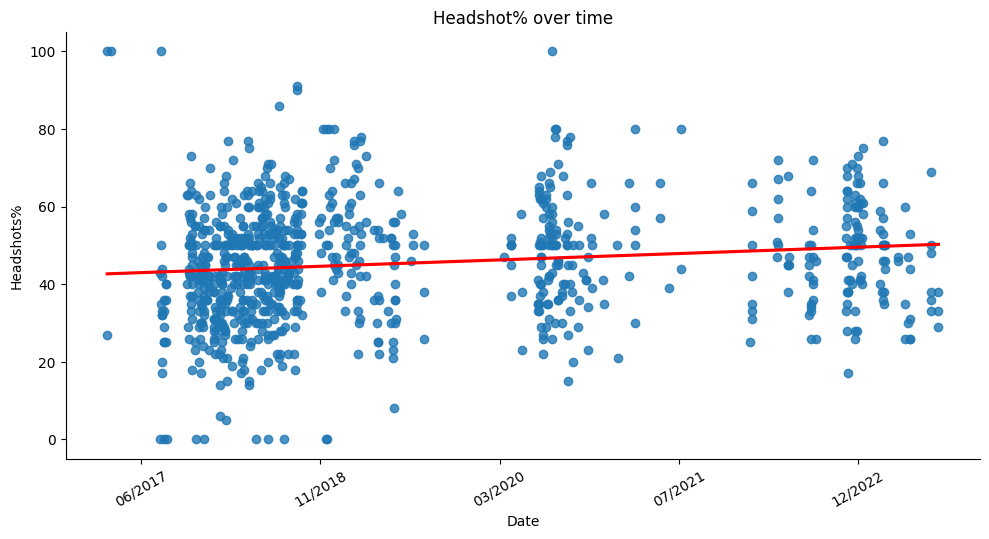

In [ ]:
g = sns.lmplot(
    data=DF_me,
    x="DateOrdinal",
    y="Headshots%",
    ci=0,
    line_kws={"color": "red"},
    facet_kws=dict(sharex=False, sharey=True),
    aspect=2,
)
# plt.title("Kills over time")
for ax in g.axes.flat:
    new_labels = [
        date.fromordinal(int(item)).strftime("%m/%Y") for item in ax.get_xticks()
    ]
    ax.set_xticklabels(new_labels, rotation=30)
    ax.set_xlabel("Date")
    ax.set_title("Headshot% over time")
plt.show()


In [ ]:
DF_me[DF_me["Headshots%"] > 95]


,index,PlayerId,Kills,Assists,Deaths,Mvps,Headshots%,Score,Map,Result,CreatedAt,SteamData,Rounds,DateOrdinal,Year,Month,Day
7184,0,2fb9fe10-5c7e-4f2f-860b-a9ee2f88801a,1,0,10,0,100,11:1,de_cbble,Lose,2017-03-17 13:00:31.295,False,12,736405,2017,3,17
7909,2,2fb9fe10-5c7e-4f2f-860b-a9ee2f88801a,2,0,18,0,100,2:16,de_mirage,Lose,2017-03-28 05:56:43.670,False,18,736416,2017,3,28
18018,6,2fb9fe10-5c7e-4f2f-860b-a9ee2f88801a,1,0,6,1,100,1:9,de_overpass,Lose,2017-08-14 07:24:37.963,False,10,736555,2017,8,14
253743,681,2fb9fe10-5c7e-4f2f-860b-a9ee2f88801a,2,2,12,0,100,12:1,de_inferno,Surrender,2020-08-10 17:11:37.000,True,13,737647,2020,8,10


C:\Users\dima1\AppData\Local\Temp\ipykernel_25332\1231991177.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(new_labels, rotation=30)


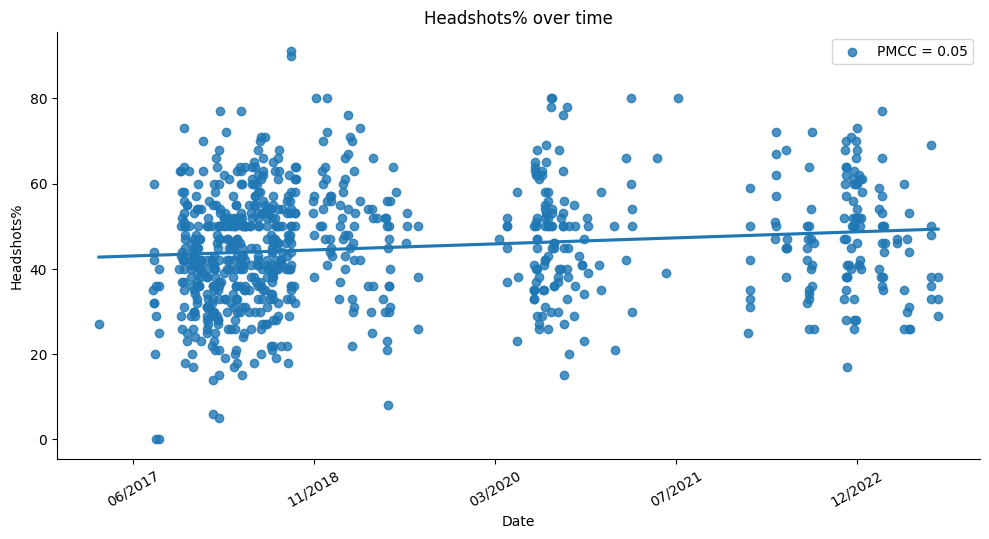

In [ ]:
data = DF_me[DF_me["Kills"] >= 10]

g = sns.lmplot(
    data=data,
    x="DateOrdinal",
    y="Headshots%",
    ci=0,
    facet_kws=dict(sharex=False, sharey=True),
    aspect=2,
)
# plt.title("Kills over time")
for ax in g.axes.flat:
    new_labels = [
        date.fromordinal(int(item)).strftime("%m/%Y") for item in ax.get_xticks()
    ]

    ax.collections[0].set_label(
        f'PMCC = {np.corrcoef(DF_me["Kills"], DF_me["DateOrdinal"])[0,1]:.2f}'
    )
    ax.set_xticklabels(new_labels, rotation=30)
    ax.set_xlabel("Date")
    ax.set_title("Headshots% over time")
    ax.legend()
# plt.show()


Text(20.513422818791945, 288, 'mean: 18')

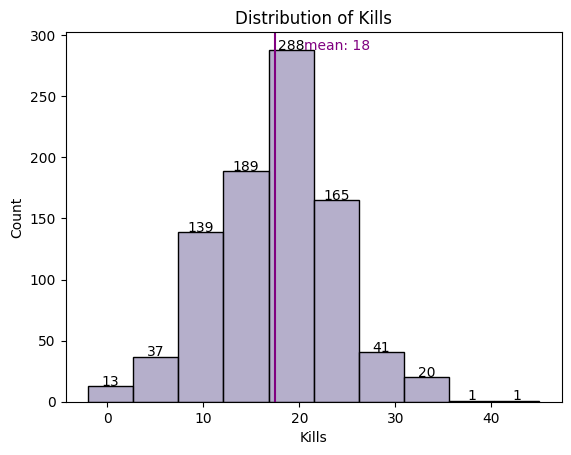

In [ ]:
ax = sns.histplot(DF_me["Kills"], color="#9d94ba", bins=10, kde=False)
ax.set(title="Distribution of Kills")
# label each bar in histogram
for p in ax.patches:
    height = p.get_height()  # get the height of each bar
    # adding text to each bar
    ax.text(
        x=p.get_x()
        + (
            p.get_width() / 2
        ),  # x-coordinate position of data label, padded to be in the middle of the bar
        y=height + 0.2,  # y-coordinate position of data label, padded 0.2 above bar
        s="{:.0f}".format(height),  # data label, formatted to ignore decimals
        ha="center",
    )

plt.axvline(DF_me["Kills"].mean(), color="purple", label="mean")
# adding data label to mean line
plt.text(
    x=DF_me["Kills"].mean()
    + 3,  # x-coordinate position of data label, adjusted to be 3 right of the data point
    y=max(
        [h.get_height() for h in ax.patches]
    ),  # y-coordinate position of data label, to take max height
    s="mean: {:.0f}".format(DF_me["Kills"].mean()),  # data label
    color="purple",
)  # colour


# https://medium.com/swlh/quick-guide-to-labelling-data-for-common-seaborn-plots-736e10bf14a9


C:\Users\dima1\AppData\Roaming\Python\Python39\site-packages\seaborn\categorical.py:3544: UserWarning: 7.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<AxesSubplot: xlabel='Map', ylabel='Headshots%'>

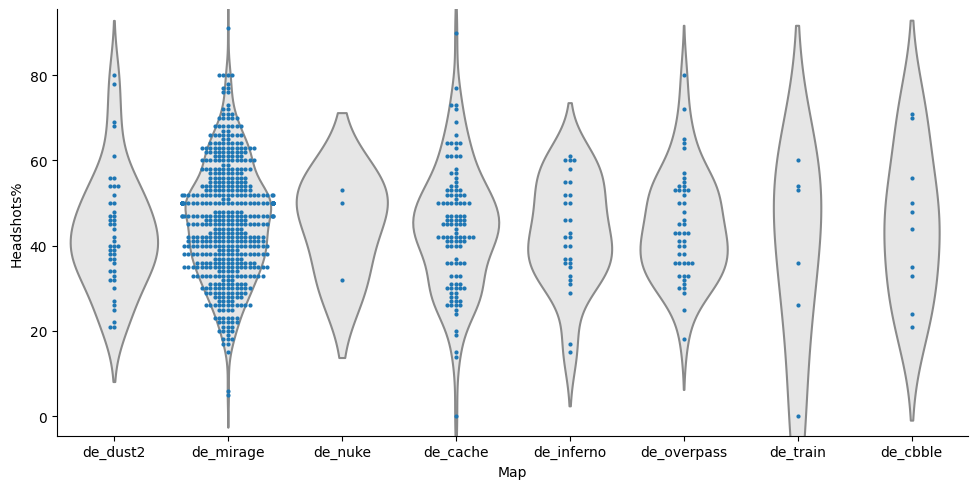

In [ ]:
data = DF_me[(DF_me["Kills"] >= 10) & (DF_me["Result"] != "Surrender")]
# sns.catplot(
#     data = data,
#     x = "Map",
#     y = "Headshots%",
#     kind = "box",
#     aspect=1.5,
# )

sns.catplot(
    data=data, x="Map", y="Headshots%", kind="violin", color=".9", inner=None, aspect=2
)
sns.swarmplot(data=data, x="Map", y="Headshots%", size=3)


In [ ]:
data


,index,PlayerId,Kills,Assists,Deaths,Mvps,Headshots%,Score,Map,Result,CreatedAt,SteamData,Rounds,DateOrdinal,Year,Month,Day
7195,1,2fb9fe10-5c7e-4f2f-860b-a9ee2f88801a,11,6,26,0,27,16:14,de_dust2,Lose,2017-03-17 13:46:49.379,False,30,736405,2017,3,17
18013,5,2fb9fe10-5c7e-4f2f-860b-a9ee2f88801a,17,8,21,3,35,14:16,de_mirage,Win,2017-08-14 07:05:32.910,False,30,736555,2017,8,14
18454,8,2fb9fe10-5c7e-4f2f-860b-a9ee2f88801a,19,2,21,2,32,14:16,de_nuke,Win,2017-08-16 07:47:50.484,False,30,736557,2017,8,16
18465,9,2fb9fe10-5c7e-4f2f-860b-a9ee2f88801a,12,6,19,2,42,16:10,de_mirage,Win,2017-08-16 08:35:16.177,False,26,736557,2017,8,16
18746,11,2fb9fe10-5c7e-4f2f-860b-a9ee2f88801a,22,13,22,1,32,19:17,de_dust2,Lose,2017-08-17 10:00:04.461,False,36,736558,2017,8,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390844,889,2fb9fe10-5c7e-4f2f-860b-a9ee2f88801a,45,7,15,8,48,13:16,de_mirage,Win,2023-07-04 14:45:58.000,True,29,738705,2023,7,4
390849,890,2fb9fe10-5c7e-4f2f-860b-a9ee2f88801a,18,2,4,4,33,16:1,de_mirage,Win,2023-07-04 15:43:26.000,True,17,738705,2023,7,4
392568,891,2fb9fe10-5c7e-4f2f-860b-a9ee2f88801a,24,8,18,3,33,16:12,de_mirage,Win,2023-07-24 12:47:49.000,True,28,738725,2023,7,24
392577,892,2fb9fe10-5c7e-4f2f-860b-a9ee2f88801a,13,6,14,3,38,5:16,de_mirage,Win,2023-07-24 14:43:01.000,True,21,738725,2023,7,24


In [ ]:
Maps


,Kills,Deaths,Mvps,TimesPlayed,Headshots%,Result,WinRate%,K/D
Map,,,,,,,,
de_mirage,10753,10013,1469,602,45.875415,294,48,1.07
de_cache,2153,2144,280,124,44.274194,57,45,1.00
de_overpass,872,946,110,55,45.363636,31,56,0.92
de_dust2,953,868,133,51,43.490196,24,47,1.10
de_inferno,549,564,66,36,42.638889,19,52,0.97
de_cbble,190,194,26,11,50.181818,6,54,0.98
de_train,107,195,9,11,41.545455,10,90,0.55
de_nuke,80,80,11,4,47.500000,2,50,1.00


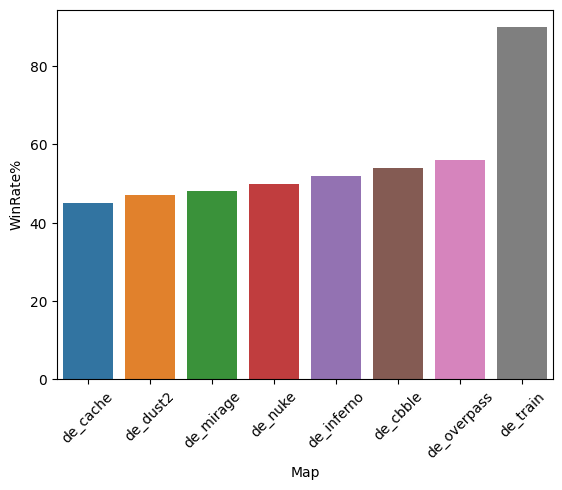

In [ ]:
sns.barplot(
    data=Maps,
    x=Maps.index,
    y=Maps["WinRate%"],
    order=Maps.sort_values(by="WinRate%").index,
)
plt.xticks(rotation=45)
plt.show()


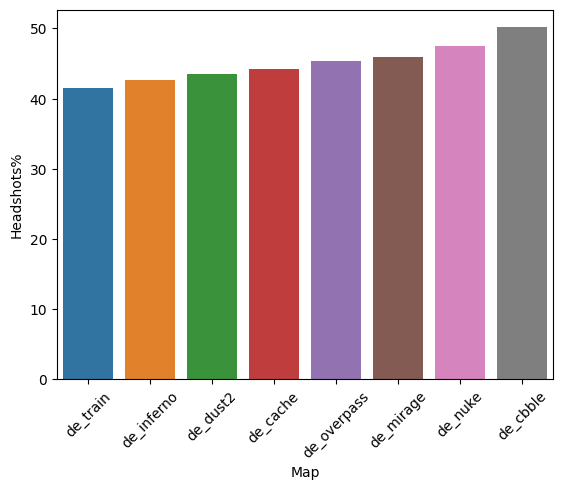

In [ ]:
sns.barplot(
    data=Maps,
    x=Maps.index,
    y=Maps["Headshots%"],
    order=Maps.sort_values(by="Headshots%").index,
)
plt.xticks(rotation=45)
plt.show()


<AxesSubplot: xlabel='Map', ylabel='WinRate%'>

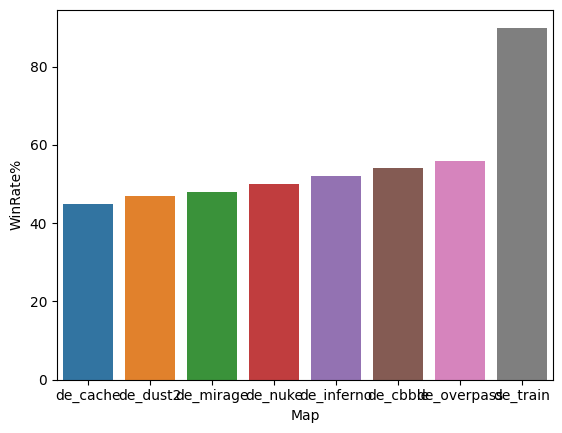

In [ ]:
sns.barplot(
    data=Maps, y="WinRate%", x=Maps.index, order=Maps.sort_values(by="WinRate%").index
)


In [ ]:
DF_me["K/D"] = DF_me["Kills"] / DF_me["Deaths"]
DF_me["K/A"] = DF_me["Kills"] / DF_me["Assists"]


C:\Users\dima1\AppData\Local\Temp\ipykernel_25332\193573094.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DF_me["K/D"] = DF_me["Kills"] / DF_me["Deaths"]
C:\Users\dima1\AppData\Local\Temp\ipykernel_25332\193573094.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DF_me["K/A"] = DF_me["Kills"] / DF_me["Assists"]


In [ ]:
DF_me.reset_index(inplace=True)


In [ ]:
data = DF_me.query("Rounds > 16").drop("index", axis=1).reset_index(drop=False)
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data[~data["K/D"].isna()].copy()


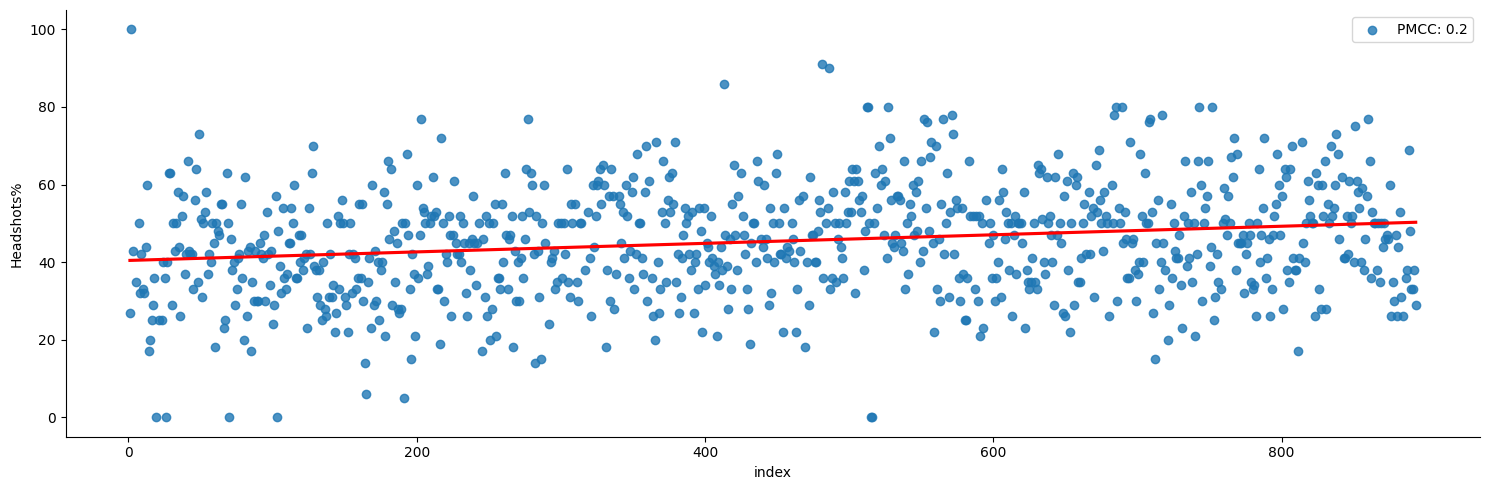

In [ ]:
g = sns.lmplot(
    data=data,
    x="index",
    y="Headshots%",
    ci=0,
    line_kws={"color": "red"},
    facet_kws=dict(sharex=False, sharey=True),
    aspect=3,
    legend=True,
    # hue = "Result"
)
g.axes[0][0].axes.collections[0].set_label(
    f"PMCC: {round(np.corrcoef(data['index'], data['Headshots%'])[0,1], 2)}"
)
plt.tight_layout()
plt.legend()
plt.show()


In [ ]:
# data = DF[(DF["K/D"] != np.inf)].drop("index", axis = 1).reset_index(drop = False)
# data.replace([np.inf, -np.inf], np.nan, inplace=True)


In [ ]:
# data = data[~data["K/D"].isna()].copy()


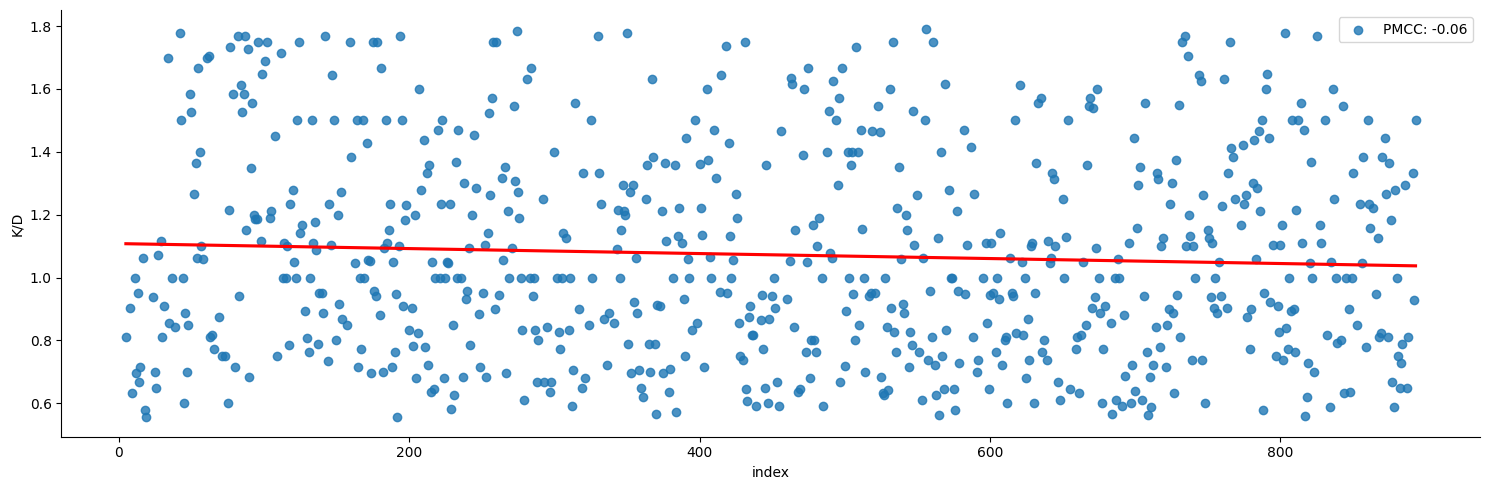

In [ ]:
q_low = DF_me["K/D"].quantile(0.1)
q_hi = DF_me["K/D"].quantile(0.9)

DF_filtered = data[(data["K/D"] < q_hi) & (data["K/D"] > q_low)]
g = sns.lmplot(
    data=DF_filtered,
    x="index",
    y="K/D",
    ci=0,
    line_kws={"color": "red"},
    facet_kws=dict(sharex=False, sharey=True),
    aspect=3,
    legend=True,
)
g.axes[0][0].axes.collections[0].set_label(
    f"PMCC: {round(np.corrcoef(DF_filtered.index, DF_filtered['K/D'])[0,1], 2)}"
)
plt.tight_layout()
plt.legend()
plt.show()


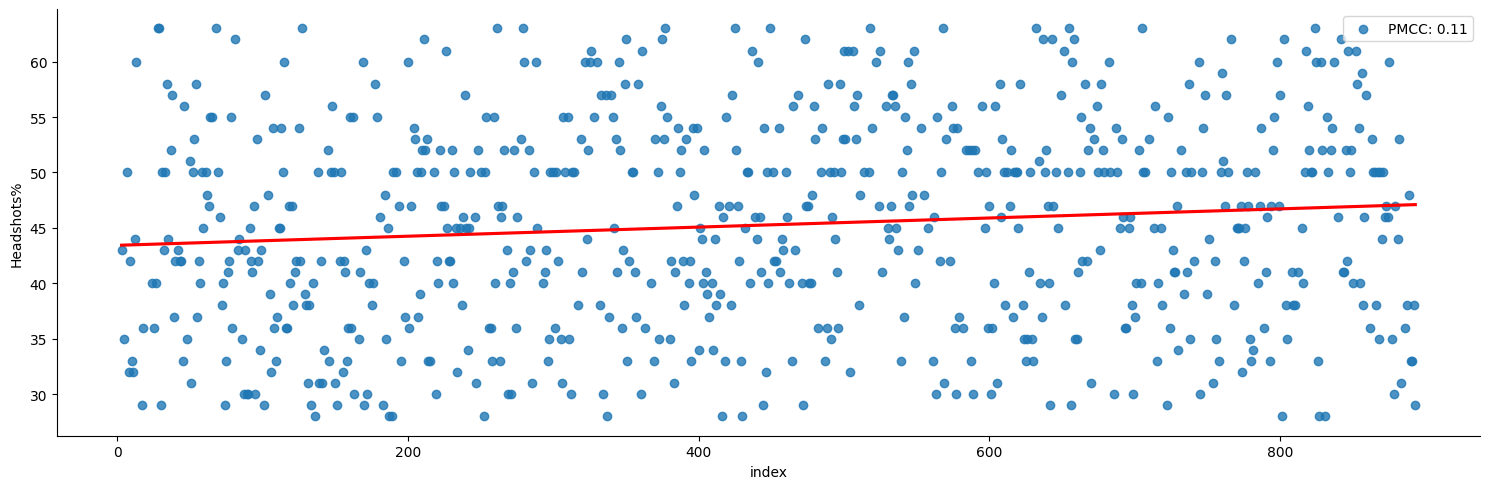

In [ ]:
q_low = DF_me["Headshots%"].quantile(0.1)
q_hi = DF_me["Headshots%"].quantile(0.9)

DF_filtered = data[(data["Headshots%"] < q_hi) & (data["Headshots%"] > q_low)]
g = sns.lmplot(
    data=DF_filtered,
    x="index",
    y="Headshots%",
    ci=0,
    line_kws={"color": "red"},
    facet_kws=dict(sharex=False, sharey=True),
    aspect=3,
    legend=True,
)
g.axes[0][0].axes.collections[0].set_label(
    f"PMCC: {round(np.corrcoef(DF_filtered.index, DF_filtered['Headshots%'])[0,1], 2)}"
)
plt.tight_layout()
plt.legend()
plt.show()


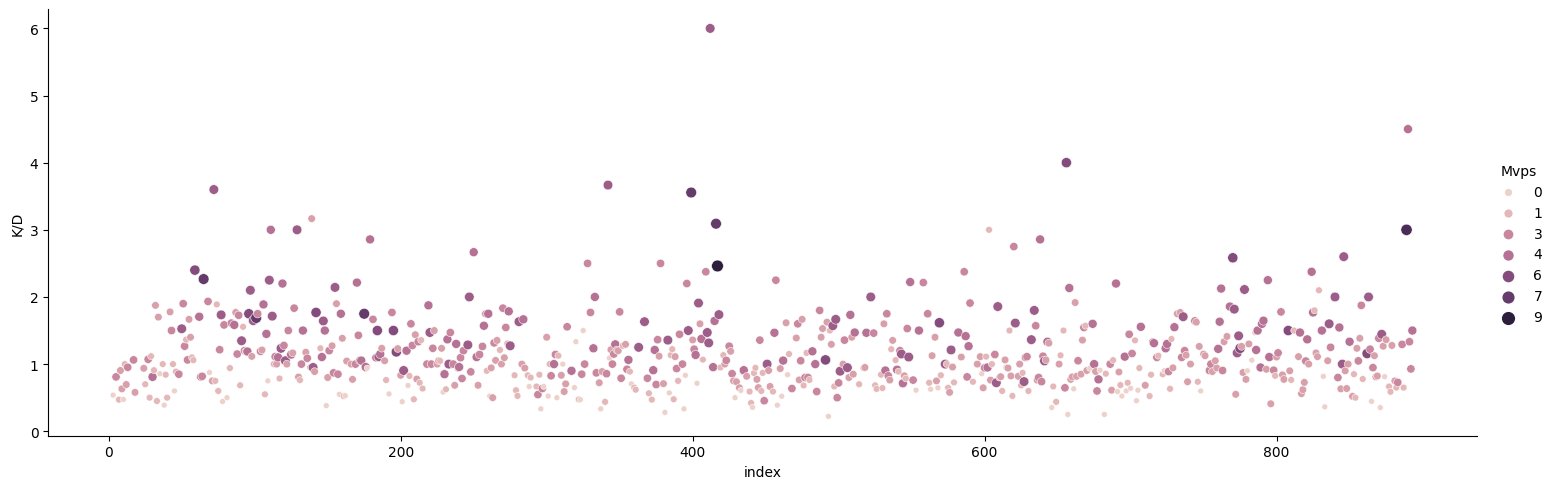

In [ ]:
sns.relplot(data=DF_filtered, x="index", y="K/D", hue="Mvps", aspect=3, size="Mvps")


([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, 'de_dust2'),
  Text(1, 0, 'de_mirage'),
  Text(2, 0, 'de_overpass'),
  Text(3, 0, 'de_cache'),
  Text(4, 0, 'de_nuke'),
  Text(5, 0, 'de_inferno'),
  Text(6, 0, 'de_train'),
  Text(7, 0, 'de_cbble')])

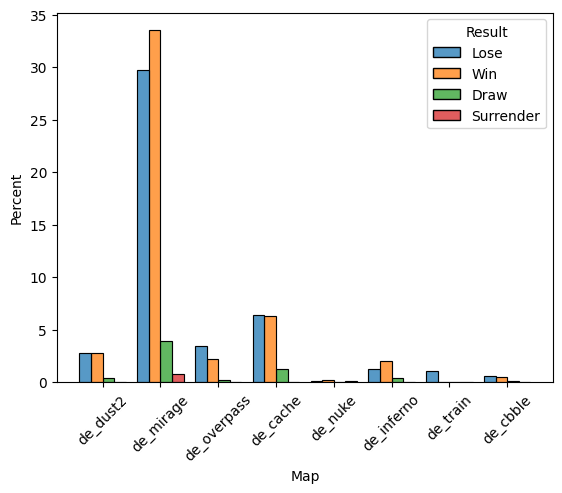

In [ ]:
sns.histplot(
    data=data,
    x="Map",
    hue="Result",
    multiple="dodge",
    shrink=0.8,
    stat="percent",
    discrete=True,
)
plt.xticks(rotation=45)


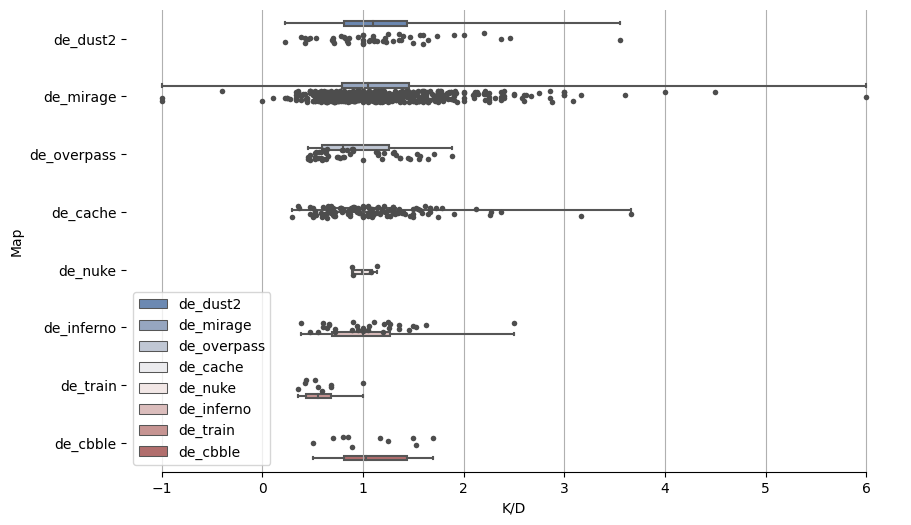

In [ ]:
# sns.set_theme(style="ticks")

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(10, 6))
# ax.set_xscale("log")

# Load the example planets dataset
# planets = sns.load_dataset("planets")

# Plot the orbital period with horizontal boxes
sns.boxplot(data, x="K/D", y="Map", hue="Map", whis=[0, 100], width=0.6, palette="vlag") # type: ignore

# Add in points to show each observation
sns.stripplot(data, x="K/D", y="Map", size=4, color=".3")

# # Tweak the visual presentation
ax.xaxis.grid(True)
# ax.set(ylabel="")
sns.despine(trim=True, left=True)


In [ ]:
g = sns.lmplot(
    data=DF_me.drop(columns="index").reset_index(drop=False),
    x="index",
    y="K/D",
    ci=0,
    col="Year",
    col_wrap=3,
    hue="Year",
    line_kws={"color": "red"},
    facet_kws=dict(sharex=False, sharey=True),
)
plt.show()


KeyError: "['K/D'] not in index"